In [227]:
#after running this, no need to restart the kurnel when you modify other files.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
import os
import math
import open3d
import csv
import numpy as np
import pandas as pd
import clusterization.clusterize as clusterizer
from settings import DATA_PATH, BASE_PATH
from utils.visualizer import save_camera_params
from utils.handling_cluster import visualize_by_cluster_bbox, crop_cluster, visualize_bbox_result
from detection.detect import compute_nearest_cluster_multicase, compute_bbox, save_bbox_result
from plane_elimination.plane_elimination import eliminate_planes
from plane_elimination.plane_equotions_list import planes_list, bool_list #list to define plane equotions
from validation.data_preprocess import butter_lowpass_filter, apply_interp_to_gt, align_dataframe, plot_validation_result, plot_validation_filtered_result

data_type_name_pcd = "LIVOX_Hallway_pcds"
experiment_name = "Walking_to_end_1st1"
dir_name = "res100ms_start30s"

#directory path of pcd files
directory_path = os.path.join(DATA_PATH, data_type_name_pcd, experiment_name, dir_name)
#'{DATA_PATH}/LIVOX_Hallway_pcds/jogging_fast_4th/res100ms_start13.5s'

#add save_path
experiment_name_clustered = experiment_name + "_clustered"
dir_name_clustered= dir_name + "_clustered"
folder_clustered = os.path.join(DATA_PATH, data_type_name_pcd, experiment_name_clustered, dir_name_clustered)

if not os.path.exists(folder_clustered):
    os.makedirs(folder_clustered)

# make the list of files
file_list = []
for filename in os.listdir(directory_path):
    if os.path.isfile(os.path.join(directory_path, filename)):
        file_list.append(os.path.join(directory_path, filename))
        
#select your view point and close your window.
pcd = open3d.io.read_point_cloud(file_list[0])
cam_params = save_camera_params(pcd)

set the view point and close the window


In [229]:
#add save_path
experiment_name_tracked = experiment_name + "_bbox_tracked"  #"jogging_fast_4th_bbox_tracked"
dir_name_tracked= dir_name + "_bbox_tracked"  #res100ms_start13.5s_bbox_tracked
folder_tracked = os.path.join(DATA_PATH, data_type_name_pcd, experiment_name_tracked, dir_name_tracked)
#.\data\LIVOX_Hallway_pcds\jogging_fast_4th_bbox_tracked\res100ms_start13.5s_bbox_tracked

if not os.path.exists(folder_tracked):
    os.makedirs(folder_tracked)

#initialization
eps = 0.6
center_prev_list = []  #initialize the center list for the next frame
center_prev = np.zeros(3) #initialize center of human cluster in previous frame
cluster_ids = []

#clusterize each files and visualize.
for i, pcd_file in enumerate(file_list):
    pcd = open3d.io.read_point_cloud(pcd_file)
    
    pcd_clustered = folder_clustered + "/" + os.path.basename(pcd_file) #pcd_clustered_save_path   
    
    #eliminate points by planes
    pcd = eliminate_planes(pcd, planes_list=planes_list, bool_list=bool_list, visualize=False)
    
    #clusterization
    pcd, labels = clusterizer.clusterize(pcd, eps=eps,
                             time_duration=None, #time duration that each windows open for. If you choose None, close window manually.
                             window_name=os.path.basename(pcd_file), #window name changes accorrding to file name.
                             cam_params=cam_params,#camera parameter(view point) you selected
                             save_path=pcd_clustered,
                             visualize=False
                             ) 
    
    
    filtered_labels = compute_bbox(pcd,labels)
    
    
    #color of points in cluster_id is changed into red.
    #pcd = change_cluster_color(pcd, labels, cluster_id=filtered_labels)
    #visualizer.visualize(pcd, time_duration=None, cam_params=cam_params)
    
    #select human cluster in first frame
    if i==0:
        visualize_by_cluster_bbox(pcd, labels, filtered_labels)
        filtered_labels = input("Please enter cluster ids, format example: 0,1,2.. ").split(',')
        filtered_labels = [int(x) for x in filtered_labels]
        
    human_clusters = np.empty((0,3))
    #select cluster id in comand line. check each window name.
    for inx, fl_label in enumerate(filtered_labels):
        if i==0:                                     # for the first frame
            cluster_id = fl_label
        else:
            inx, cluster_id = compute_nearest_cluster_multicase(pcd, labels, fl_label, center_prev_list)
            
        #crop (and save) selected cluser
        cropped_pcd = crop_cluster(pcd, labels, cluster_id=cluster_id, visualize=False)
        
        center_tmp = cropped_pcd.get_center()

        
        if i==0:   
            center_prev_list.append([inx, center_tmp])

            # save the cropped cluster(pcd, save_path)
            save_bbox_result(inx, folder_tracked, pcd_file, cropped_pcd)

            human_clusters = np.append(human_clusters, cropped_pcd.points, axis=0)
            
        else:  #update center if current cluster is close to previous one
            center_prev = center_prev_list[inx][1]
            current_dist = np.linalg.norm (center_prev - center_tmp)
            if 0.1< current_dist < 5:
                #update the previous center list
                center_prev_list[inx][1] = center_tmp
                # save the cropped cluster(pcd, save_path)
                save_bbox_result(inx, folder_tracked, pcd_file, cropped_pcd)
                
                human_clusters = np.append(human_clusters, cropped_pcd.points, axis=0)

    # visulize the bbox result of each frame
    visualize_bbox_result(pcd, human_clusters, time_duration=0.2, cam_params=cam_params, visualize=True)


num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered_labels: [0]
num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered_labels: []
num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered_labels: []
num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered_labels: []
num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered_labels: [0]
num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered_labels: []
num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered_labels: []
num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered_labels: []
num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered_labels: []
num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered_labels: [0]
num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered_labels: [0]
num_clusters 1
Cluster -1 Bounding Box:
Cluster 0 Bounding Box:
filtered

AssertionError: cluster was not found by db_scan.try again by higher eps!!

In [230]:
#### get center of mass of the cluster and calculate velocity ###

# get each subfolders in folder_tracked (different players if exist)
subfolders = [f.path for f in os.scandir(folder_tracked) if f.is_dir()]

for subfolder in subfolders:
    print(f"Processing folder: {subfolder}")
    subfolder_name = os.path.basename(subfolder)
    
    center_list = []
    time_list = []
    pcd_files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(".pcd")]
    
    # Extracting file names without the ".pcd" extension
    pcd_names_without_extension = [os.path.splitext(os.path.basename(pcd_file))[0] for pcd_file in pcd_files]

    for pcd_file in pcd_files:
        print(f"Reading PCD file: {pcd_file}")
        
        # file name without extension (frame time)
        frame_time = os.path.splitext(os.path.basename(pcd_file))[0]
        
        # read point cloud cluster
        point_cloud = open3d.io.read_point_cloud(pcd_file)
        
        # get center of cluster
        center = point_cloud.get_center()
        
        center_list.append(center) 
        time_list.append(frame_time)  # unit: ms

    
    # calculate velocity
    # take only the x,y-axis
    centers_xy = [row[:2] for row in center_list]
    time_list = [float(num) for num in time_list]
    
    velocities = []
    csv_data = []
    
    for i in range(1, len(centers_xy)):
        # calculate displacement
        displacement_x = centers_xy[i][0] - centers_xy[i - 1][0]
        displacement_y = centers_xy[i][1] - centers_xy[i - 1][1]

        # calculate time interval
        time_interval = time_list[i] - time_list[i - 1]

        velocity_x = 1000 * displacement_x / time_interval  # *1000 cuz of the time unit is ms
        velocity_y = 1000 * displacement_y / time_interval

        velocity = math.sqrt(velocity_x**2 + velocity_y**2)
        
        velocities.append(velocity)
        
        csv_data.append((time_list[i], velocity))


    # save velocity data to a csv file
    csv_file = "velocity.csv"
    csv_path = os.path.join(folder_tracked, subfolder_name, csv_file)
    
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        writer.writerow(['Time', 'Velocity'])

        for time, velocity in csv_data:
            writer.writerow([time, velocity])


print("end")



Processing folder: C:/Users/yangx/Desktop/LaserScanning/test_data\LIVOX_Hallway_pcds\Walking_to_end_1st1_bbox_tracked\res100ms_start30s_bbox_tracked\0_class
Reading PCD file: C:/Users/yangx/Desktop/LaserScanning/test_data\LIVOX_Hallway_pcds\Walking_to_end_1st1_bbox_tracked\res100ms_start30s_bbox_tracked\0_class\00000.pcd
Reading PCD file: C:/Users/yangx/Desktop/LaserScanning/test_data\LIVOX_Hallway_pcds\Walking_to_end_1st1_bbox_tracked\res100ms_start30s_bbox_tracked\0_class\00100.pcd
Reading PCD file: C:/Users/yangx/Desktop/LaserScanning/test_data\LIVOX_Hallway_pcds\Walking_to_end_1st1_bbox_tracked\res100ms_start30s_bbox_tracked\0_class\00200.pcd
Reading PCD file: C:/Users/yangx/Desktop/LaserScanning/test_data\LIVOX_Hallway_pcds\Walking_to_end_1st1_bbox_tracked\res100ms_start30s_bbox_tracked\0_class\00300.pcd
Reading PCD file: C:/Users/yangx/Desktop/LaserScanning/test_data\LIVOX_Hallway_pcds\Walking_to_end_1st1_bbox_tracked\res100ms_start30s_bbox_tracked\0_class\00400.pcd
Reading PCD f

Complete the original data alignment !!!!
Minimum Root Mean Square Error(RMSE): 0.45416847369984886
Best Offset: 21
Complete the filtered data alignment !!!!
Minimum Root Mean Square Error(RMSE): 0.35456270275114266
Best Offset with filter: 0


c:\Users\yangx\Desktop\LaserScanning\lidar_in_soccer\validation\data_preprocess.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gt_interp = cs_interpolate(chunk)
c:\Users\yangx\Desktop\LaserScanning\lidar_in_soccer\validation\data_preprocess.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gt_interp = cs_interpolate(chunk)


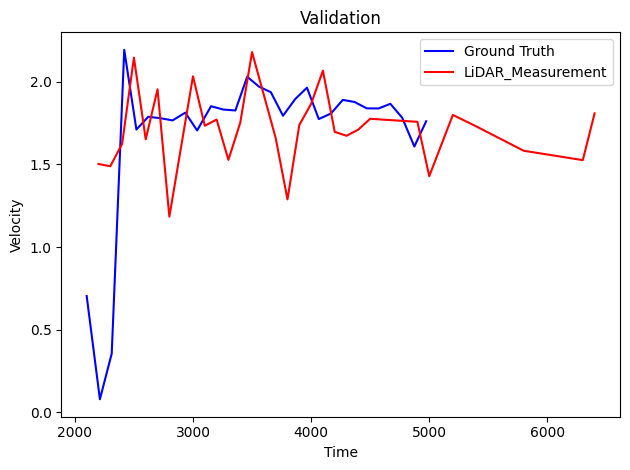

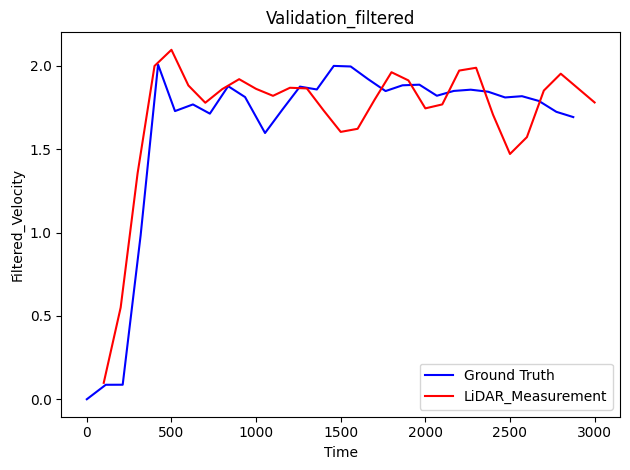

Finish!


In [298]:
########## obtain and preprocess all csv data ###########
# directory path of measurement csv file
ms_folder = "0_class"
ms_file = "velocity.csv"
ms_directory_path = os.path.join(BASE_PATH, folder_tracked, ms_folder, ms_file)
ms = pd.read_csv(ms_directory_path)

# directory path of ground truth csv file
gt_folder = "Data"
gt_file_name = "Run_1.csv"
gt_directory_path = os.path.join(BASE_PATH, gt_folder, gt_file_name)
gt = pd.read_csv(gt_directory_path)

# remove rows containing NaN values
gt = gt.dropna()

# save velocity data without NaN to a csv file
gt_cleaned_csv = "velocity_gt_cleaned.csv"
gt_cleaned_path = os.path.join(folder_tracked, subfolder_name, gt_cleaned_csv)
gt.to_csv(gt_cleaned_path, index=False)



############### butter filter #####################
ms_cutoff_frequency = 2.0  # cut-off frequency
ms_sample_rate = 10.0  # sampling rate

gt_cutoff_frequency = 2.0  # cut-off frequency
gt_sample_rate = 300.0  # sampling rate

ms_filtered_velocity = butter_lowpass_filter(ms['Velocity'], ms_cutoff_frequency, ms_sample_rate)
ms['Filtered_Velocity'] = ms_filtered_velocity

gt_filtered_velocity = butter_lowpass_filter(gt['Velocity'], gt_cutoff_frequency, gt_sample_rate)
gt['Filtered_Velocity'] = gt_filtered_velocity


############### CubicSpline Interpolation ###############
# Interpolation of values every 100 counts (time intervals = 0.1s)
chunk_size = 100

# apply to the original gt data
# define the save path
gt_interp_csv = "velocity_gt_interp.csv"
gt_interp_path = os.path.join(folder_tracked, subfolder_name, gt_interp_csv)

gt_new = apply_interp_to_gt(gt, gt_interp_path, chunk_size, filter=False)



# apply to the filtered gt data
# define the save path
gt_f_interp_csv = "velocity_gt_filtered_interp.csv"
gt_f_interp_path = os.path.join(folder_tracked, subfolder_name, gt_f_interp_csv)

gt_f_new = apply_interp_to_gt(gt, gt_f_interp_path, chunk_size, filter=True)


############# align the groundtruth and measurement data ############
# apply to the original gt data
len_diff = len(gt_new) - len(ms)
min_rmse, best_chunk, best_offset = align_dataframe(gt_new, ms, len_diff, filter=False)

print(f"Complete the original data alignment !!!!")
print(f"Minimum Root Mean Square Error(RMSE): {min_rmse}")
print(f"Best Offset: {best_offset}")

# apply to the filtered gt data
len_diff_f = len(gt_f_new) - len(ms)
min_rmse_f, best_chunk_f, best_offset_f = align_dataframe(gt_f_new, ms, len_diff_f, filter=True)

print(f"Complete the filtered data alignment !!!!")
print(f"Minimum Root Mean Square Error(RMSE): {min_rmse_f}")
print(f"Best Offset with filter: {best_offset_f}")



#################### plot #####################
# plot the result without the filter
plot_validation_result(len_diff, best_chunk, gt_new, ms)

# plot the result with the filter
plot_validation_filtered_result(len_diff_f, best_chunk_f, gt_f_new, ms)



print("Finish!")
